### Load packages

In [26]:
import pandas as pd
import os
import textwrap
import numpy as np

# for figures
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
import geopandas as gpd
from shapely.geometry import Point
from pandas.plotting import scatter_matrix

### Set project parameters for this run

In [27]:
# Project parameters

data_directory = "..\data"

algae_file = "env-epht-cyanobacteria-season-summary-2022"
algae_path = os.path.join(data_directory, algae_file + ".csv")
print(algae_path)

..\data\env-epht-cyanobacteria-season-summary-2022.csv


### Load algae bloom data

In [28]:
# Load algae bloom data file

algae_raw_df = pd.read_csv(algae_path)

In [29]:
algae_raw_df.columns

Index(['Report Date', 'Report Time', 'Waterbody', 'Region', 'Municipality',
       'Site', 'Station', 'Bloom Intensity', 'ApproximateShoreLengthOfBloom',
       'ApproximateOffShoreLengthBloom', 'Report Frequency', 'Affiliation',
       'Web Status', 'Details', 'Water Temperature', 'Water Surface',
       'CyanoTaxa', 'Density', 'OtherTaxa', 'Plankton_Sampling_Method',
       'Microcystin', 'Anatoxin', 'CYN_uGL', 'Latitude', 'Longitude'],
      dtype='object')

In [30]:
# algae_raw_df.iloc[:10, 0:10]
algae_raw_df.iloc[:10, 10:25]

,Report Frequency,Affiliation,Web Status,Details,Water Temperature,Water Surface,CyanoTaxa,Density,OtherTaxa,Plankton_Sampling_Method,Microcystin,Anatoxin,CYN_uGL,Latitude,Longitude
0,Routine - Biweekly,VT DEC,Generally Safe,NaN,76.0,Rolling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.714009,-73.383001
1,Routine - Biweekly,VT DEC,Generally Safe,NaN,77.0,Calm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.714009,-73.383001
2,Routine - Biweekly,VT DEC,Generally Safe,NaN,57.0,Calm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.714009,-73.383001
3,Routine - Biweekly,VT DEC,Generally Safe,NaN,52.0,Rolling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.714009,-73.383001
4,Routine - Weekly,LCC Volunteer,Generally Safe,NaN,NaN,Rolling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.149521,-73.367368
5,Routine - Weekly,LCC Volunteer,Generally Safe,NaN,NaN,Rolling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.149414,-73.367368
6,Routine - Weekly,LCC Volunteer,Generally Safe,NaN,NaN,Calm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.149521,-73.367368
7,Routine - Weekly,LCC Volunteer,Generally Safe,NaN,NaN,Rolling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.149447,-73.367341
8,Routine - Weekly,LCC Volunteer,Generally Safe,NaN,NaN,Rolling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.149502,-73.367248
9,Routine - Weekly,LCC Volunteer,Generally Safe,NaN,NaN,Rolling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.149438,-73.367372


In [31]:
# Convert number columns to floats and integers as appropriate

algae_numcols_df = algae_raw_df.copy()

float_cols = ["Water Temperature", "Density", "Microcystin", "Latitude", "Longitude"]
int_cols = ["Site"]

algae_numcols_df[float_cols] = algae_numcols_df[float_cols].apply(pd.to_numeric, errors="coerce")

algae_numcols_df[int_cols] = (algae_numcols_df[int_cols].apply(pd.to_numeric, errors="coerce").astype("Int64"))

algae_numcols_df[["Site", "Water Temperature", "Density", "Microcystin", "Latitude", "Longitude"]].head()

,Site,Water Temperature,Density,Microcystin,Latitude,Longitude
0,2,76.0,NaN,NaN,43.714009,-73.383001
1,2,77.0,NaN,NaN,43.714009,-73.383001
2,2,57.0,NaN,NaN,43.714009,-73.383001
3,2,52.0,NaN,NaN,43.714009,-73.383001
4,3,NaN,NaN,NaN,44.149521,-73.367368


In [32]:
# Uppercase all categorical columns

algae_upper_df = algae_raw_df.copy()

cat_cols = ["Waterbody", "Region", "Municipality", "Station", "Report Frequency", "Affiliation",
            "Web Status", "Water Surface", "Plankton_Sampling_Method",
            "CyanoTaxa", "Microcystin", "Anatoxin"]

algae_upper_df[cat_cols] = algae_upper_df[cat_cols].apply(
    lambda col: col.where(col.isna(), col.str.upper())
)

algae_upper_df.head()

,Report Date,Report Time,Waterbody,Region,Municipality,Site,Station,Bloom Intensity,ApproximateShoreLengthOfBloom,ApproximateOffShoreLengthBloom,...,Water Surface,CyanoTaxa,Density,OtherTaxa,Plankton_Sampling_Method,Microcystin,Anatoxin,CYN_uGL,Latitude,Longitude
0,8/1/2022,10:45 AM,LAKE CHAMPLAIN,CHAMPLAIN - SOUTH LAKE,BENSON,2.0,LTM 02,1b - No Cyanobacteria Observed - brown or turb...,NaN,NaN,...,ROLLING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.714009,-73.383001
1,8/22/2022,10:00 AM,LAKE CHAMPLAIN,CHAMPLAIN - SOUTH LAKE,BENSON,2.0,LTM 02,1b - No Cyanobacteria Observed - brown or turb...,NaN,NaN,...,CALM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.714009,-73.383001
2,10/5/2022,10:30 AM,LAKE CHAMPLAIN,CHAMPLAIN - SOUTH LAKE,BENSON,2.0,LTM 02,1b - No Cyanobacteria Observed - brown or turb...,NaN,NaN,...,CALM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.714009,-73.383001
3,10/21/2022,10:30 AM,LAKE CHAMPLAIN,CHAMPLAIN - SOUTH LAKE,BENSON,2.0,LTM 02,1b - No Cyanobacteria Observed - brown or turb...,NaN,NaN,...,ROLLING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.714009,-73.383001
4,6/23/2022,2:35 PM,LAKE CHAMPLAIN,CHAMPLAIN - MAIN LAKE SOUTH,PANTON,3.0,ARNOLD BAY,1a - No Cyanobacteria Observed - clear water,NaN,NaN,...,ROLLING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.149521,-73.367368


In [33]:
# Translate Bloom Intensity columns

algae_bloom_df = algae_upper_df.copy()

algae_bloom_df["Bloom Intensity Code"] = (algae_bloom_df["Bloom Intensity"].astype(str).str[:2]
                                          .str.strip()
                                          .where(algae_bloom_df["Bloom Intensity"].notna())
)

algae_bloom_df["Bloom Intensity Sum"] = (algae_bloom_df["Bloom Intensity"].astype(str).str[:1]
                                          .str.strip()
                                          .where(algae_bloom_df["Bloom Intensity"].notna())
                                          .astype("Int64")
)
# algae_bloom_df[["Bloom Intensity Code", "Bloom Intensity"]]
print("Bloom Intensity Code:", algae_bloom_df["Bloom Intensity Code"].unique())
print("Bloom Intensity Sum:", algae_bloom_df["Bloom Intensity Sum"].unique())

Bloom Intensity Code: ['1b' '1a' '1c' '1d' '2' '3' nan]
Bloom Intensity Sum: <IntegerArray>
[1, 2, 3, <NA>]
Length: 4, dtype: Int64


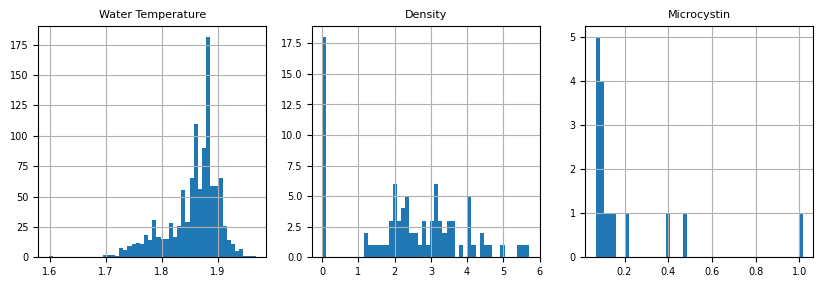

In [34]:
# Plot histograms of the numerical columns in the data

cols_to_use = ["Water Temperature", "Density", "Microcystin"]

use_log_values = True

plot_df =  algae_bloom_df[cols_to_use].apply(pd.to_numeric, errors="coerce")

# Compute logs if needed
if use_log_values:
    safe_plot_df = plot_df.where(plot_df > -1)
    safe_plot_df = np.log10(safe_plot_df + 1)
else:
    safe_plot_df = plot_df.copy()

# drop columns that are all nulls or NaN values
safe_plot_df = safe_plot_df.dropna(axis=1, how="all")

# axes = log_df.hist(bins=50, figsize=(7.5, 4))
axes = safe_plot_df.hist(bins=50, figsize=(10, 3), layout=(1, 3))

for ax in axes.flatten():
    title = ax.get_title()
    wrapped_title = "\n".join(textwrap.wrap(title, width=20))
    ax.set_title(wrapped_title, fontsize=8)
    ax.tick_params(axis="y", labelsize=7)
    ax.tick_params(axis="x", labelsize=7)

plt.subplots_adjust(hspace=0.2, wspace=0.2)

plt.show()


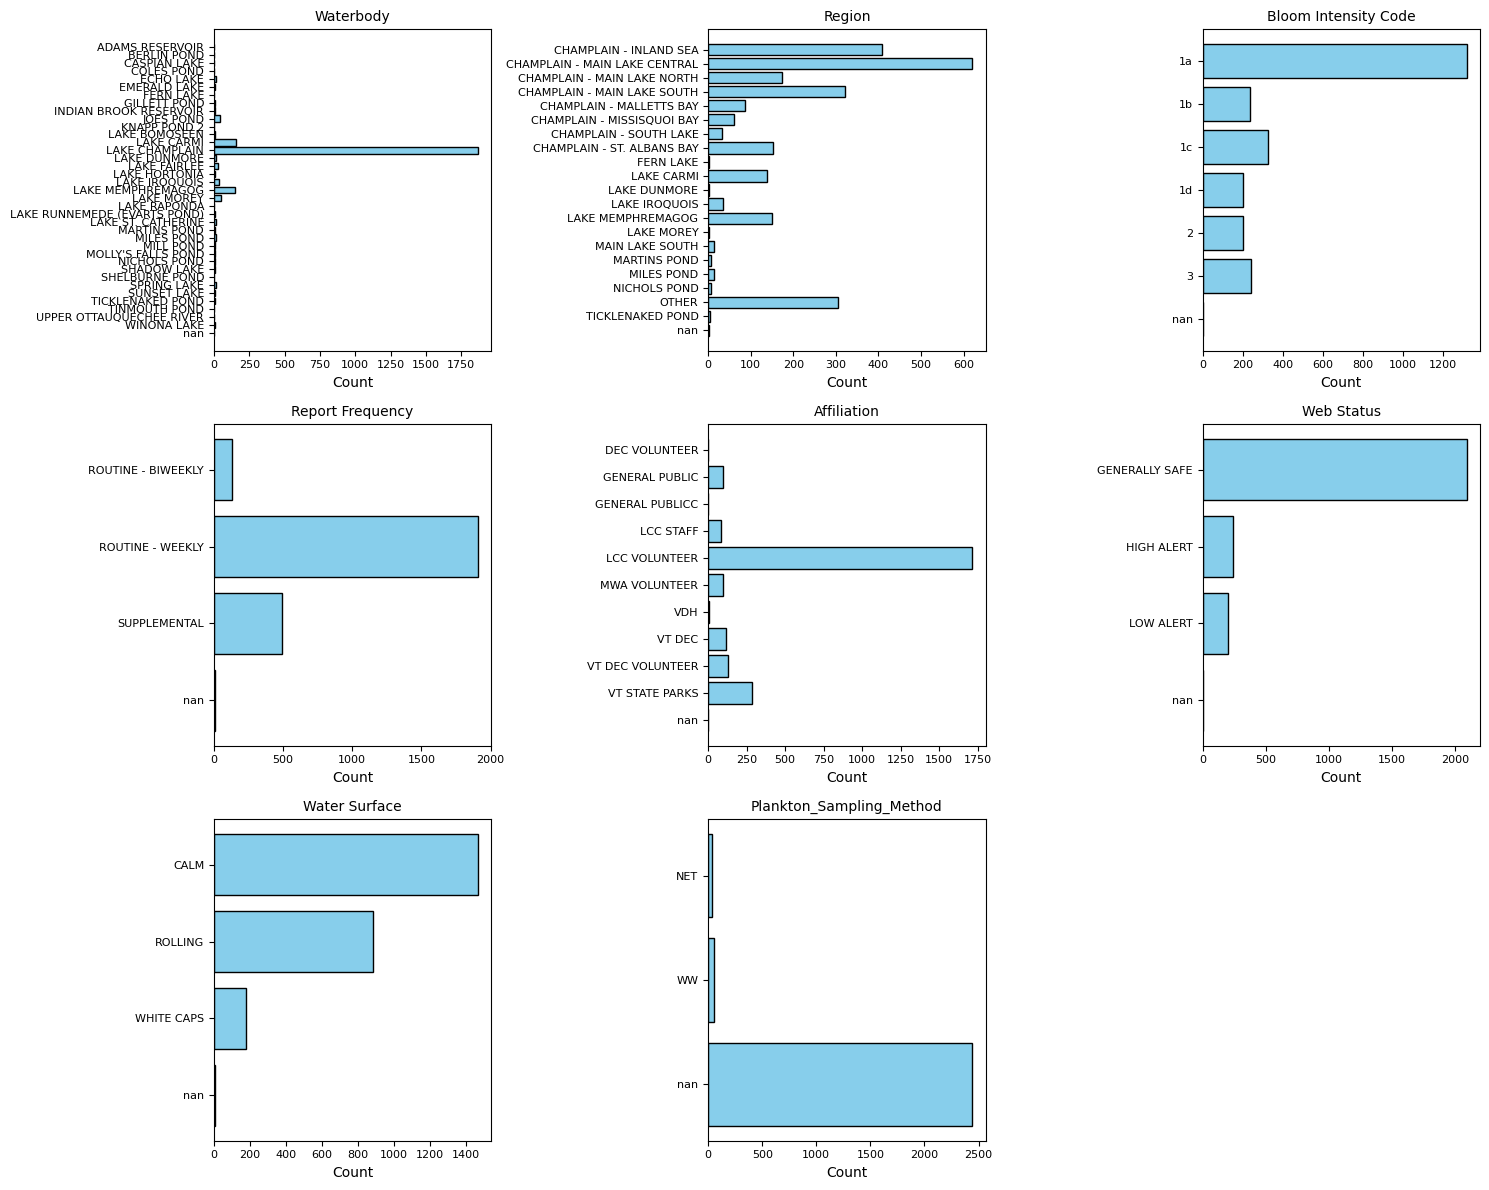

In [35]:
# plot bar charts for all the categorical columns

cat_cols = ["Waterbody", "Region", "Bloom Intensity Code", "Report Frequency", "Affiliation",
            "Web Status", "Water Surface", "Plankton_Sampling_Method"]

n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  

for i, col in enumerate(cat_cols):
    counts = algae_bloom_df[col].value_counts(dropna=False).sort_index() 
    axes[i].barh(counts.index.astype(str), counts.values, color="skyblue", edgecolor="black")
    
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel("") 
    axes[i].tick_params(axis="y", labelsize=8)
    axes[i].tick_params(axis="x", labelsize=8)

    axes[i].invert_yaxis()

# Remove any empty subplots if number of columns isn't a multiple of 3
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [36]:
# Find number of values for columns with tons of values

big_cols = ["Site", "Station", "Municipality", "CyanoTaxa", "OtherTaxa", "CYN_uGL"]

for big_col in big_cols:
    print(f"Number of unique values in {big_col}: {algae_bloom_df[big_col].nunique()}")

Number of unique values in Site: 216
Number of unique values in Station: 253
Number of unique values in Municipality: 75
Number of unique values in CyanoTaxa: 73
Number of unique values in OtherTaxa: 0
Number of unique values in CYN_uGL: 0


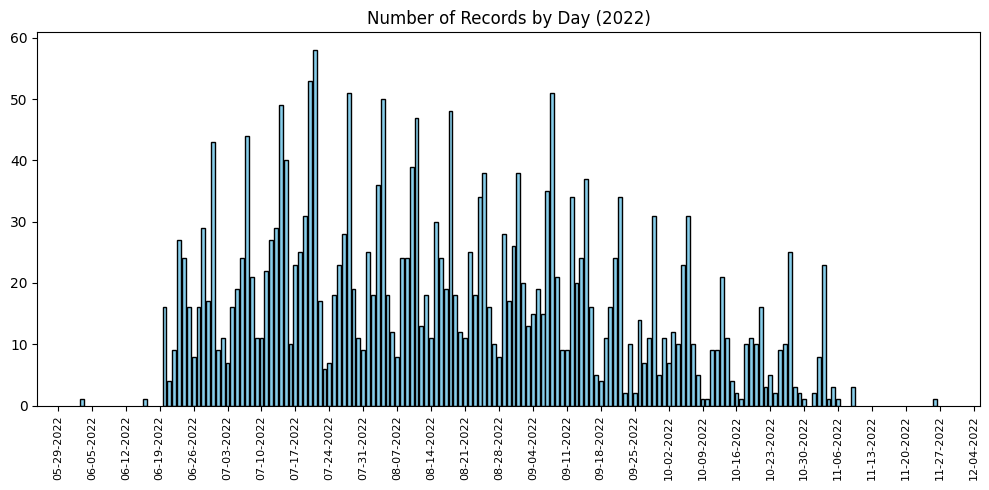

In [37]:
# Time plot - all records

algae_bloom_df["Report Date"] = pd.to_datetime(algae_bloom_df["Report Date"])

date_counts = algae_bloom_df["Report Date"].value_counts().sort_index()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(date_counts.index, date_counts.values, color="skyblue", edgecolor="black")

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.tick_params(axis="x", labelrotation=90, labelsize=8) 

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Number of Records by Day (2022)")

plt.tight_layout()
plt.show()

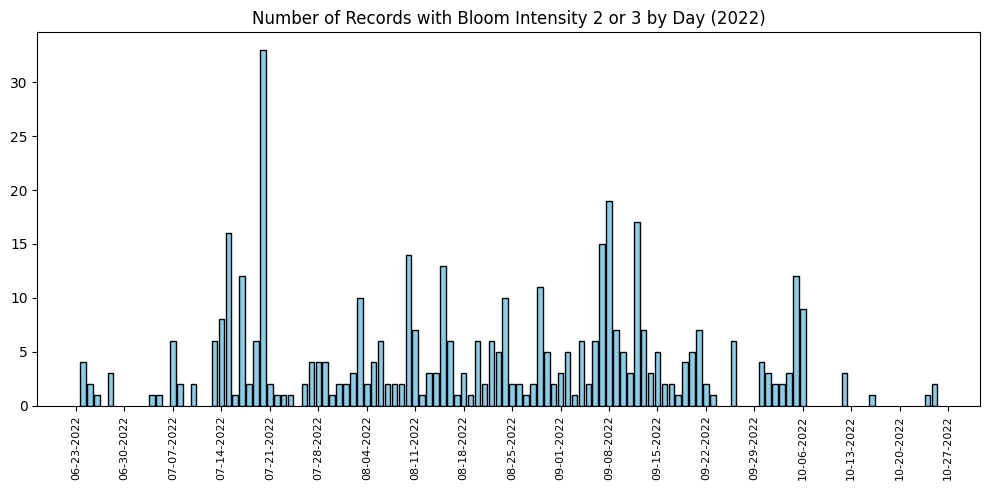

In [38]:
# Time plot - records with blooms

algae_bloom_df["Report Date"] = pd.to_datetime(algae_bloom_df["Report Date"])

blooms_only_df = algae_bloom_df[(algae_bloom_df["Bloom Intensity Code"] == "2") | (algae_bloom_df["Bloom Intensity Code"] == "3")]

date_counts = blooms_only_df["Report Date"].value_counts().sort_index()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(date_counts.index, date_counts.values, color="skyblue", edgecolor="black")

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%Y"))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.tick_params(axis="x", labelrotation=90, labelsize=8) 

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Number of Records with Bloom Intensity 2 or 3 by Day (2022)")

plt.tight_layout()
plt.show()

In [39]:
# Compute correlation coefficients for every number variable

corr_cols = ["Water Temperature", "Density", "Microcystin"]

corr_matrix = safe_plot_df.corr()

for corr_col in corr_cols:
    print(corr_matrix[corr_col].sort_values(ascending=False).round(2), "\n")


Water Temperature    1.0
Density              0.3
Microcystin          0.3
Name: Water Temperature, dtype: float64 

Density              1.00
Microcystin          0.61
Water Temperature    0.30
Name: Density, dtype: float64 

Microcystin          1.00
Density              0.61
Water Temperature    0.30
Name: Microcystin, dtype: float64 



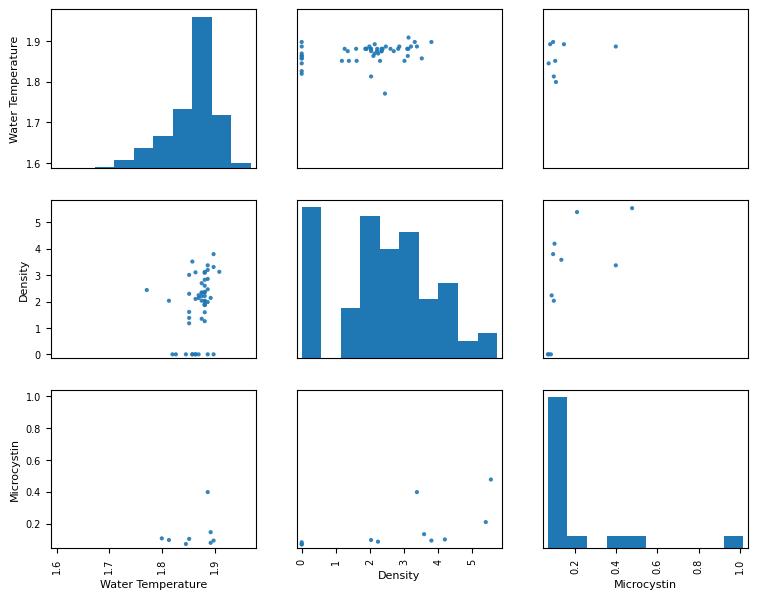

In [40]:
# Calculate scatterplots for every number variable pair

use_log_values = True

scatter_cols = ["Water Temperature", "Density", "Microcystin"]
plot_df = algae_bloom_df[scatter_cols].apply(pd.to_numeric, errors="coerce")

# Compute logs if needed
if use_log_values:
    safe_plot_df = plot_df.where(plot_df > -1)
    safe_plot_df = np.log10(safe_plot_df + 1)
else:
    safe_plot_df = plot_df.copy()
    
axes = scatter_matrix(safe_plot_df[scatter_cols], figsize=(9,7), alpha=0.9)

for ax in axes.flatten():
    
    ax.tick_params(axis="x", labelsize=7)
    ax.tick_params(axis="y", labelsize=7)
    xlabel = ax.get_xlabel()
    wrapped_xlabel = "\n".join(textwrap.wrap(xlabel, width=20))
    ax.set_xlabel(wrapped_xlabel, fontsize=8)
    ylabel = ax.get_ylabel()
    wrapped_ylabel = "\n".join(textwrap.wrap(ylabel, width=20))
    ax.set_ylabel(wrapped_ylabel, fontsize=8)

plt.subplots_adjust(hspace=0.2, wspace=0.2)

plt.show()

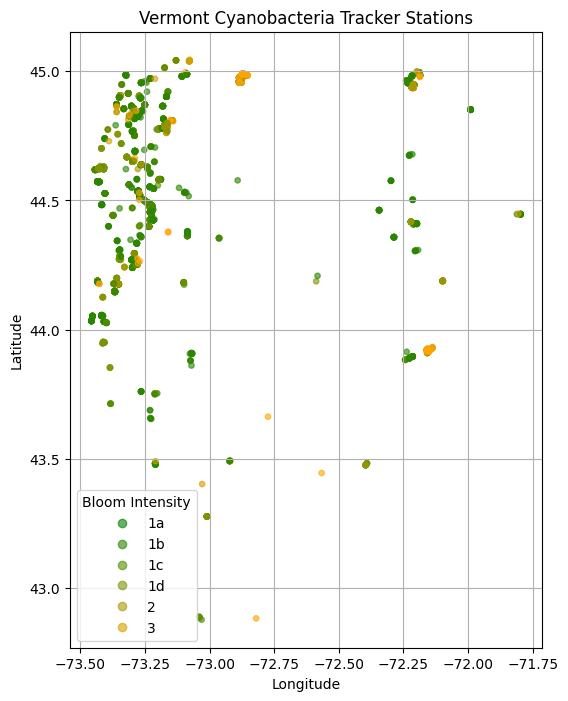

In [46]:
# Geography

algae_latlong_df = algae_bloom_df[algae_bloom_df["Longitude"] > -74]

cmap = LinearSegmentedColormap.from_list("green_orange", ["green", "orange"])
color_codes = algae_latlong_df["Bloom Intensity Code"]

fig, ax = plt.subplots(figsize=(8, 8))

codes_numeric = color_codes.astype("category").cat.codes

scatter = ax.scatter(
    algae_latlong_df["Longitude"], 
    algae_latlong_df["Latitude"], 
    s=15, 
    c=codes_numeric, 
    alpha=0.6,
    cmap=cmap
)

# legend
handles, _ = scatter.legend_elements()
labels = color_codes.astype("category").cat.categories
ax.legend(handles, labels, title="Bloom Intensity")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Vermont Cyanobacteria Tracker Stations")
plt.grid(True)

ax.set_aspect("equal", adjustable="box")

plt.show()

In [42]:
nw_hot_spot_df = algae_bloom_df[(algae_bloom_df["Longitude"] > -73)
                           & (algae_bloom_df["Longitude"] < -72.75) 
                           & (algae_bloom_df["Latitude"] > 44.75)]

se_hot_spot_df = algae_bloom_df[(algae_bloom_df["Longitude"] > -72.19)
                           & (algae_bloom_df["Longitude"] < -72) 
                           & (algae_bloom_df["Latitude"] > 44)]

hot_spots_df = pd.concat([nw_hot_spot_df, se_hot_spot_df], ignore_index=True)

print(len(hot_spots_df))
print(hot_spots_df["Waterbody"].nunique())
print(hot_spots_df["Waterbody"].value_counts())
hot_spots_df.head()


180
3
Waterbody
LAKE CARMI           154
LAKE MEMPHREMAGOG     16
TICKLENAKED POND      10
Name: count, dtype: int64


,Report Date,Report Time,Waterbody,Region,Municipality,Site,Station,Bloom Intensity,ApproximateShoreLengthOfBloom,ApproximateOffShoreLengthBloom,...,Density,OtherTaxa,Plankton_Sampling_Method,Microcystin,Anatoxin,CYN_uGL,Latitude,Longitude,Bloom Intensity Code,Bloom Intensity Sum
0,2022-06-23,2:40 PM,LAKE CARMI,LAKE CARMI,FRANKLIN,164.0,"LAKE CARMI, BLACK WOODS",1a - No Cyanobacteria Observed - clear water,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,44.975457,-72.885668,1a,1
1,2022-06-30,11:15 AM,LAKE CARMI,LAKE CARMI,FRANKLIN,164.0,"LAKE CARMI, BLACK WOODS",1c - No Cyanobacteria Observed - other materia...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,44.975306,-72.885461,1c,1
2,2022-07-14,2:50 PM,LAKE CARMI,LAKE CARMI,FRANKLIN,164.0,"LAKE CARMI, BLACK WOODS",3 - Cyano bloom in progress (include photos),500 ft,50 ft,...,NaN,NaN,NaN,NaN,NaN,NaN,44.975116,-72.885883,3,3
3,2022-07-14,1:20 PM,LAKE CARMI,LAKE CARMI,FRANKLIN,164.0,"LAKE CARMI, BLACK WOODS",1d - Little Cyano Observed - recreation not im...,unknown,15 ft,...,NaN,NaN,NaN,NaN,NaN,NaN,44.975306,-72.885461,1d,1
4,2022-07-28,10:15 AM,LAKE CARMI,LAKE CARMI,FRANKLIN,164.0,"LAKE CARMI, BLACK WOODS",1c - No Cyanobacteria Observed - other materia...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,44.975299,-72.885461,1c,1


In [43]:
algae_raw_df["CyanoTaxa"].unique()


array([nan,
       'Aphanizomenon flos-aquae;Limnotrhix;Microcystis aeruginosa;Aphanothece;Pseudanabaena;Microcystis sp. (pico)',
       'Aphanizomenon flos-aquae;Dolichospermum sp;Dolichospermum planctonicum;Limnotrhix;Microcystis aeruginosa',
       'Aphanizomenon flos-aquae;Dolichospermum crassum var. spiroides;Dolichospermum sp;Dolichospermum planctonicum;Limnotrhix',
       'none', 'Dolichospermum sp;Snowella Sp.', 'Dolichospermum sp',
       'Dolichospermum planctonicum', 'Microcystis aeruginosa',
       'Aphanizomenon flos-aquae;Dolichospermum sp;Dolichospermum crassum var. spiroides;Pseudanabaena;Limnotrhix',
       'Aphanizomenon flos-aquae;Dolichospermum sp;Dolichospermum crassum var. spiroides;Dolichospermum planctonicum;Microcystis weisenbergii;Microcystis aeruginosa',
       'Aphanizomenon flos-aquae;Dolichospermum crassum var. spiroides;Dolichospermum sp;Dolichospermum planctonicum;Microcystis aeruginosa;Microcystis sp. (pico);Microcystis weisenbergii',
       'Aphanizome

In [44]:
# Get Vermont shapefile

states = gpd.read_file("../shapefiles/cb_2021_us_state_20m.shp")
vermont = states[states.NAME == "Vermont"]

vermont

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
46,50,01779802,0400000US50,50,VT,Vermont,00,23872569964,1030754609,"POLYGON ((-73.41632 44.09942, -73.39977 44.152..."
